In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-15 16:53:54.215026: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/Dataset/dataset_3/training"
val_path = "/drive0-storage/Gracia/Dataset/dataset_3/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 16:53:57.482221: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:53:58.276819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 16332 files belonging to 3 classes.
Found 4080 files belonging to 3 classes.


In [ ]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 244.90761
(184, 216, 3)


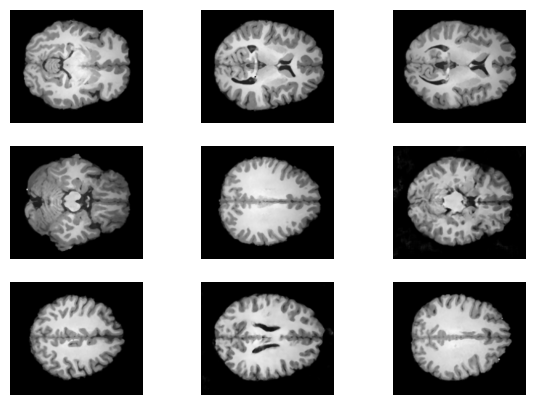

In [5]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [5]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [6]:
print(len(validation_dataset))
print(len(test_dataset))

64
64


## Model building

In [7]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [8]:
with tf.device("GPU"):
    model = build_vgg16()

    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [9]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn3_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [10]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-15 16:54:17.563989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-15 16:54:18.555441: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


511/511 [==============================] - 31s 53ms/step - loss: 1.0646 - accuracy: 0.4248 - val_loss: 1.0816 - val_accuracy: 0.3893
Epoch 2/30
511/511 [==============================] - 27s 52ms/step - loss: 0.8734 - accuracy: 0.5705 - val_loss: 0.9503 - val_accuracy: 0.5531
Epoch 3/30
511/511 [==============================] - 27s 52ms/step - loss: 0.7080 - accuracy: 0.6686 - val_loss: 0.8837 - val_accuracy: 0.5595
Epoch 4/30
511/511 [==============================] - 26s 52ms/step - loss: 0.5882 - accuracy: 0.7373 - val_loss: 0.8255 - val_accuracy: 0.6137
Epoch 5/30
511/511 [==============================] - 26s 52ms/step - loss: 0.4458 - accuracy: 0.8109 - val_loss: 0.6803 - val_accuracy: 0.6747
Epoch 6/30
511/511 [==============================] - 26s 52ms/step - loss: 0.2919 - accuracy: 0.8869 - val_loss: 0.3903 - val_accuracy: 0.8484
Epoch 7/30
511/511 [==============================] - 26s 52ms/step - loss: 0.1836 - accuracy: 0.9330 - val_loss: 0.4475 - val_accuracy: 0.8223
Epo

In [11]:
model.save('./models_retrain/cnn3_14epoch.h5')

### Training evaluation

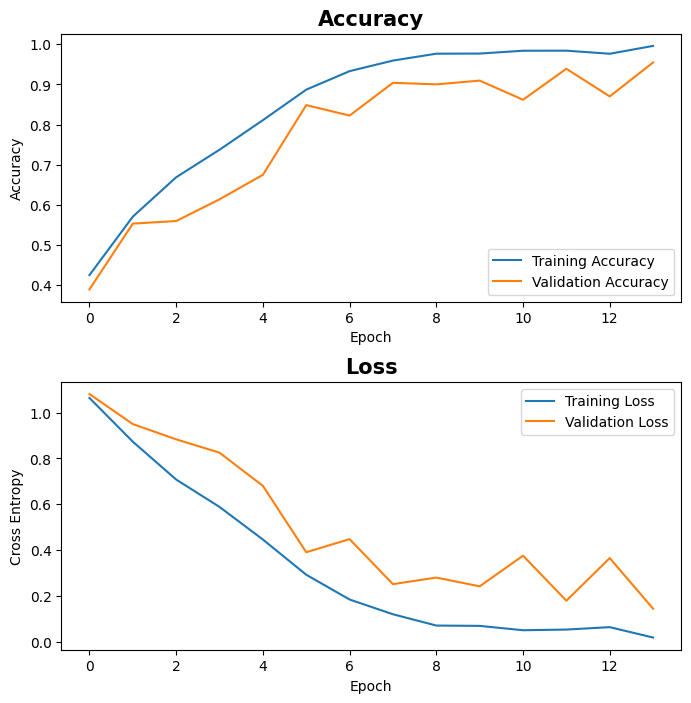

In [12]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [13]:
acc

[0.4248102009296417,
 0.570475161075592,
 0.6686260104179382,
 0.7372642755508423,
 0.8109233379364014,
 0.8869091272354126,
 0.9330149292945862,
 0.9594048261642456,
 0.9765490889549255,
 0.9768552780151367,
 0.9838966727256775,
 0.9840803146362305,
 0.9763654470443726,
 0.9959588646888733]

In [14]:
val_acc

[0.38927164673805237,
 0.5531495809555054,
 0.5595472455024719,
 0.6136810779571533,
 0.6747047305107117,
 0.8484252095222473,
 0.8223425149917603,
 0.9040354490280151,
 0.900098443031311,
 0.9094488024711609,
 0.8617125749588013,
 0.9389764070510864,
 0.8700787425041199,
 0.9547244310379028]

In [15]:
loss

[1.0646181106567383,
 0.8734069466590881,
 0.7080140709877014,
 0.5882375836372375,
 0.44583120942115784,
 0.291854590177536,
 0.1835664063692093,
 0.11914503574371338,
 0.0697803869843483,
 0.06834166496992111,
 0.049332261085510254,
 0.05227966234087944,
 0.0628093034029007,
 0.017346952110528946]

In [16]:
val_loss

[1.0815953016281128,
 0.9503275752067566,
 0.8837020397186279,
 0.8254818320274353,
 0.6802508234977722,
 0.39029660820961,
 0.4474526345729828,
 0.2507815361022949,
 0.27948662638664246,
 0.24125492572784424,
 0.3752017021179199,
 0.17843645811080933,
 0.3647678792476654,
 0.1434095948934555]

## Testing

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [18]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

64/64 [==============================] - 1s 20ms/step - loss: 0.1724 - accuracy: 0.9468


{'loss': 0.17238415777683258, 'accuracy': 0.94677734375}

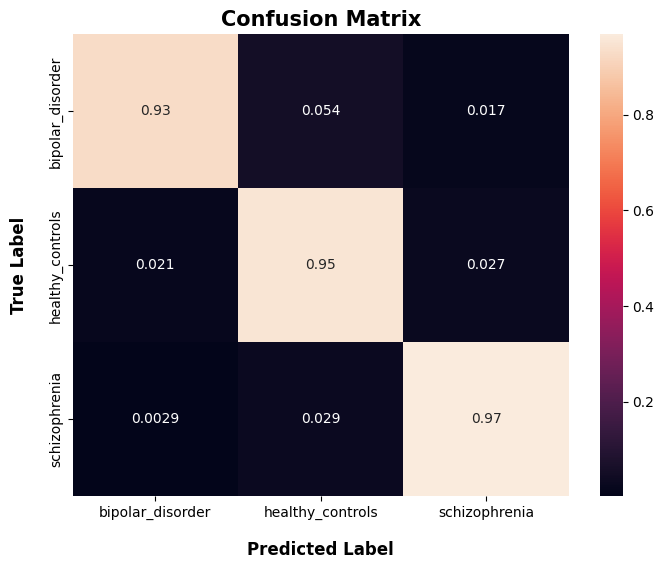

In [19]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN3_cm.png')
plt.show()

In [20]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.94677734375
Precision: 0.9500482607317368
Sensitivity: 0.94921875
Specificity: 0.9747047905069971
